
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Юрий Кашницкий (@yorko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 10 (демо)
## <center> Прогнозирование задержек вылетов

Ваша задача – побить единственный бенчмарк в [соревновании](https://www.kaggle.com/c/flight-delays-2017) на Kaggle Inclass. Подробных инструкций не будет, будет только тезисно описано, как получен этот бенчмарк. Конечно, с помощью Xgboost. Надеюсь, на данном этапе курса вам достаточно бросить полтора взгляда на данные, чтоб понять, что это тот тип задачи, в которой затащит Xgboost. Но проверьте еще Catboost.

<img src='../../img/xgboost_meme.jpg' width=40% />

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
train = pd.read_csv("flight_delays_train.csv")
test = pd.read_csv("flight_delays_test.csv")

In [3]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


Итак, надо по времени вылета самолета, коду авиакомпании-перевозчика, месту вылета и прилета и расстоянию между аэропортами вылета и прилета предсказать задержку вылета более 15 минут. В качестве простейшего бенчмарка возьмем логистическую регрессию и два признака, которые проще всего взять: `DepTime` и `Distance`. У такой модели результат – 0.68202 на LB. 

In [13]:
X_train, y_train = (
    train[["Distance", "DepTime"]].values,
    train["dep_delayed_15min"].map({"Y": 1, "N": 0}).values,
)
X_test = test[["Distance", "DepTime"]].values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=17
)

# Логистическая регрессия 

In [6]:
logit = LogisticRegression(random_state=17)

logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

0.6795697123357751

In [7]:
logit.fit(X_train, y_train)
logit_test_pred = logit.predict_proba(X_test)[:, 1]

pd.Series(logit_test_pred, name="dep_delayed_15min").to_csv(
    "logit_2feat.csv", index_label="id", header=True
)

# AdaBoost & DecisionTreeClassifier

In [10]:
from urllib.request import urlopen

import numpy as np

%matplotlib inline
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.datasets import load_boston, load_digits, load_iris
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [15]:
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

# AdaBoost
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=42).fit(
    X_train, y_train
)

print("Decision tree accuracy: %.2f" % dt.score(X_valid, y_valid))
print("AdaBoost accuracy: %.2f" % ada.score(X_valid, y_valid))

Decision tree accuracy: 0.98
AdaBoost accuracy: 0.81


In [16]:
roc_auc_score(y_valid, dt.predict_proba(X_valid)[:, 1])

0.9986331275113065

In [17]:
roc_auc_score(y_valid, ada.predict_proba(X_valid)[:, 1])

0.6940911638824869

# Xgboost

In [18]:
xgb_model = xgb.XGBClassifier(random_state=42).fit(X_train, y_train)

In [19]:
print("Xgboost accuracy: %.2f" % xgb_model.score(X_valid, y_valid))

Xgboost accuracy: 0.82


In [20]:
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

0.7582434396609115

# GradientBoostingClassifier

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
clf = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)

In [23]:
print("GradientBoostingClassifier accuracy: %.2f" % clf.score(X_valid, y_valid))

GradientBoostingClassifier accuracy: 0.82


In [24]:
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])

0.7021006033210676

# Оценка важности признаков с Xgboost

In [34]:
X_all_train, y_all_train = train.drop('dep_delayed_15min', axis=1), train['dep_delayed_15min']

In [36]:
X_all_train_enc, y_all_train_enc = pd.get_dummies(X_all_train), pd.get_dummies(y_all_train)

In [37]:
dtrain = xgb.DMatrix(X_all_train_enc, y_all_train_enc)

In [38]:
#dtest = xgb.DMatrix(X_valid, y_valid)

In [41]:
params = {"objective": "binary:logistic", "max_depth": 3, "silent": 1, "eta": 0.5}
num_rounds = 50

In [42]:
watchlist = [(dtrain, "train")]  # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[13:41:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-logloss:0.53149
[1]	train-logloss:0.47932
[2]	train-logloss:0.45835
[3]	train-logloss:0.44968
[4]	train-logloss:0.44551
[5]	train-logloss:0.44316
[6]	train-logloss:0.44163
[7]	train-logloss:0.44033
[8]	train-logloss:0.43931
[9]	train-logloss:0.43827
[10]	train-logloss:0.43715
[11]	train-logloss:0.43638
[12]	train-logloss:0.43560
[13]	train-logloss:0.43468
[14]	train-logloss:0.43388
[15]	train-logloss:0.43335
[16]	train-logloss:0.43274
[17]	train-logloss:0.43216
[18]	train-logloss:0.43161
[19]	train-logloss:0.43127
[20]	train-logloss:0.43087
[21]	train-logloss:0.43032
[22]	train-logloss:0.42993
[23]	train-logloss:0.42943
[24]	train-logloss:0.42905
[25]	train-logloss:0.42843
[26]	train-logloss:0.42810
[27]	train-logloss:0.42766
[28]	train-logloss:0.42726
[29]	train-logloss:0.42698
[30]

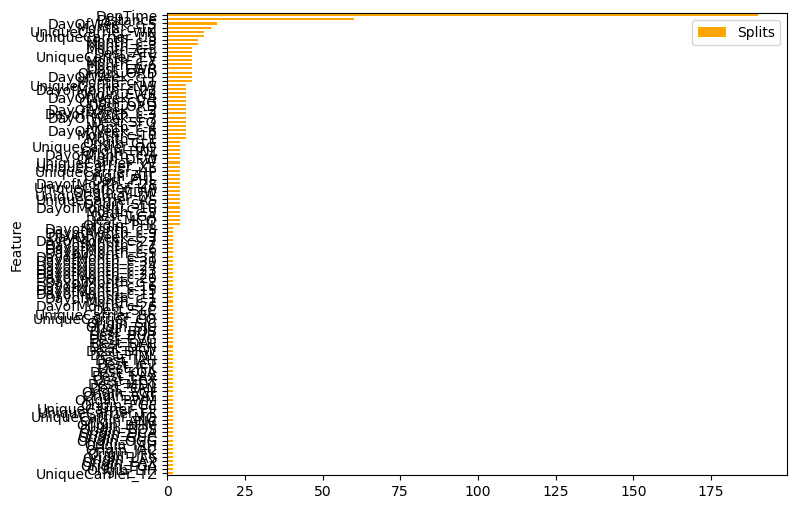

In [43]:
# create df
importance_df = pd.DataFrame(
    {"Splits": list(xgb_model.get_fscore().values()), "Feature": list(xgb_model.get_fscore().keys())}
)
importance_df.sort_values(by="Splits", inplace=True)
importance_df.plot(kind="barh", x="Feature", figsize=(8, 6), color="orange")
importance_df.figsize

In [45]:
xgb_model.get_fscore()

{'DepTime': 190.0,
 'Distance': 60.0,
 'Month_c-1': 6.0,
 'Month_c-10': 6.0,
 'Month_c-11': 8.0,
 'Month_c-12': 14.0,
 'Month_c-2': 2.0,
 'Month_c-3': 10.0,
 'Month_c-4': 6.0,
 'Month_c-5': 8.0,
 'Month_c-6': 8.0,
 'Month_c-7': 8.0,
 'Month_c-8': 10.0,
 'Month_c-9': 4.0,
 'DayofMonth_c-1': 2.0,
 'DayofMonth_c-10': 4.0,
 'DayofMonth_c-11': 2.0,
 'DayofMonth_c-15': 2.0,
 'DayofMonth_c-16': 2.0,
 'DayofMonth_c-2': 2.0,
 'DayofMonth_c-20': 2.0,
 'DayofMonth_c-21': 2.0,
 'DayofMonth_c-22': 6.0,
 'DayofMonth_c-23': 2.0,
 'DayofMonth_c-24': 2.0,
 'DayofMonth_c-26': 2.0,
 'DayofMonth_c-27': 2.0,
 'DayofMonth_c-28': 4.0,
 'DayofMonth_c-3': 6.0,
 'DayofMonth_c-30': 2.0,
 'DayofMonth_c-31': 2.0,
 'DayofMonth_c-4': 4.0,
 'DayofMonth_c-5': 2.0,
 'DayofMonth_c-6': 2.0,
 'DayofMonth_c-7': 2.0,
 'DayofMonth_c-8': 2.0,
 'DayofMonth_c-9': 2.0,
 'DayOfWeek_c-1': 8.0,
 'DayOfWeek_c-2': 6.0,
 'DayOfWeek_c-3': 2.0,
 'DayOfWeek_c-4': 6.0,
 'DayOfWeek_c-5': 16.0,
 'DayOfWeek_c-6': 6.0,
 'DayOfWeek_c-7': 6.0,


# StratifiedKFold

In [46]:
from sklearn.model_selection import StratifiedKFold, validation_curve

In [47]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [49]:
default_params = {
    "objective": "binary:logistic",
    "max_depth": 1,
    "learning_rate": 0.3,
    "silent": 1.0,
    "seed": 42,
}

n_estimators_range = np.linspace(1, 200, 10).astype("int")

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X_train,
    y_train,
    param_name="n_estimators",
    param_range=n_estimators_range,
    cv=cv.split(X_train, y_train),
    scoring="accuracy",
    n_jobs=-1,
)

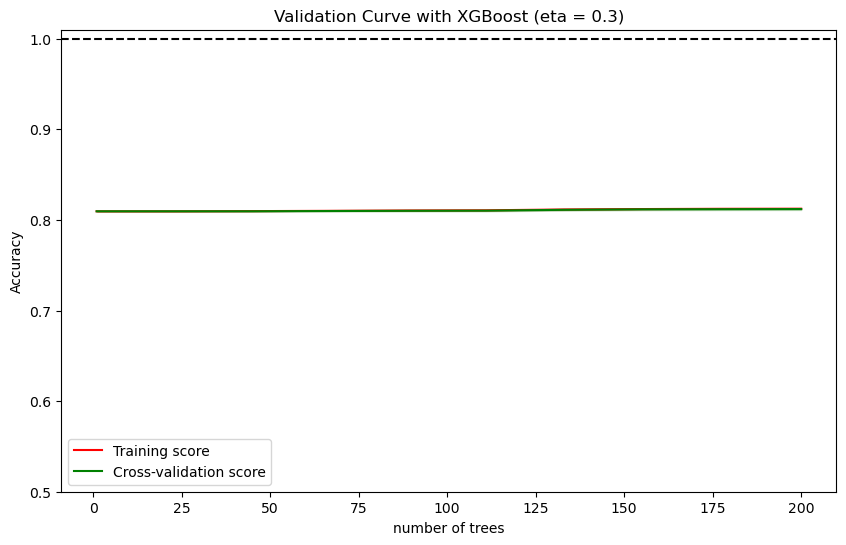

Best cross-validation result (0.81) obtained for 200 trees


In [50]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.01)

plt.plot(n_estimators_range, train_scores_mean, label="Training score", color="r")

plt.plot(
    n_estimators_range, test_scores_mean, label="Cross-validation score", color="g"
)

plt.fill_between(
    n_estimators_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="r",
)

plt.fill_between(
    n_estimators_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="g",
)

plt.axhline(y=1, color="k", ls="dashed")

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print(
    "Best cross-validation result ({0:.2f}) obtained for {1} trees".format(
        test_scores_mean[i], n_estimators_range[i]
    )
)

# CatBoost

In [53]:
from catboost import CatBoostClassifier

In [54]:
ctb = CatBoostClassifier(random_seed=42)

In [58]:
train_df_part, valid_df, y_train_part, y_valid = train_test_split(
    X_all_train, y_all_train , test_size=0.3, random_state=17)

In [59]:
cat_features_idx = np.where(train_df_part.dtypes == "object")[0].tolist()

In [61]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [62]:
%%time
cv_scores = []
for train_idx, test_idx in skf.split(train_df_part, y_train_part):
    cv_train_df, cv_valid_df = (
        train_df_part.iloc[train_idx, :],
        train_df_part.iloc[test_idx, :],
    )
    y_cv_train, y_cv_valid = y_train_part.iloc[train_idx], y_train_part.iloc[test_idx]

    ctb.fit(cv_train_df, y_cv_train, cat_features=cat_features_idx)

    cv_scores.append(roc_auc_score(y_cv_valid, ctb.predict_proba(cv_valid_df)[:, 1]))

Learning rate set to 0.057466
0:	learn: 0.6642140	total: 116ms	remaining: 1m 55s
1:	learn: 0.6369281	total: 168ms	remaining: 1m 23s
2:	learn: 0.6133910	total: 215ms	remaining: 1m 11s
3:	learn: 0.5930458	total: 261ms	remaining: 1m 4s
4:	learn: 0.5760571	total: 286ms	remaining: 56.9s
5:	learn: 0.5609815	total: 330ms	remaining: 54.6s
6:	learn: 0.5483551	total: 355ms	remaining: 50.3s
7:	learn: 0.5377857	total: 373ms	remaining: 46.3s
8:	learn: 0.5272524	total: 415ms	remaining: 45.7s
9:	learn: 0.5175724	total: 460ms	remaining: 45.5s
10:	learn: 0.5105473	total: 485ms	remaining: 43.6s
11:	learn: 0.5044351	total: 504ms	remaining: 41.5s
12:	learn: 0.4982278	total: 530ms	remaining: 40.2s
13:	learn: 0.4932374	total: 575ms	remaining: 40.5s
14:	learn: 0.4889262	total: 598ms	remaining: 39.3s
15:	learn: 0.4855660	total: 629ms	remaining: 38.7s
16:	learn: 0.4816298	total: 679ms	remaining: 39.2s
17:	learn: 0.4790955	total: 704ms	remaining: 38.4s
18:	learn: 0.4745629	total: 753ms	remaining: 38.9s
19:	lear

162:	learn: 0.4223739	total: 7.57s	remaining: 38.9s
163:	learn: 0.4223025	total: 7.62s	remaining: 38.9s
164:	learn: 0.4221809	total: 7.67s	remaining: 38.8s
165:	learn: 0.4221251	total: 7.72s	remaining: 38.8s
166:	learn: 0.4220205	total: 7.78s	remaining: 38.8s
167:	learn: 0.4219803	total: 7.83s	remaining: 38.8s
168:	learn: 0.4218507	total: 7.88s	remaining: 38.7s
169:	learn: 0.4217542	total: 7.93s	remaining: 38.7s
170:	learn: 0.4216961	total: 7.99s	remaining: 38.7s
171:	learn: 0.4216295	total: 8.03s	remaining: 38.7s
172:	learn: 0.4215373	total: 8.09s	remaining: 38.7s
173:	learn: 0.4214781	total: 8.13s	remaining: 38.6s
174:	learn: 0.4214147	total: 8.18s	remaining: 38.6s
175:	learn: 0.4213398	total: 8.23s	remaining: 38.6s
176:	learn: 0.4212827	total: 8.28s	remaining: 38.5s
177:	learn: 0.4212007	total: 8.33s	remaining: 38.5s
178:	learn: 0.4211563	total: 8.38s	remaining: 38.4s
179:	learn: 0.4210670	total: 8.43s	remaining: 38.4s
180:	learn: 0.4209861	total: 8.49s	remaining: 38.4s
181:	learn: 

324:	learn: 0.4118199	total: 16.2s	remaining: 33.6s
325:	learn: 0.4117714	total: 16.3s	remaining: 33.6s
326:	learn: 0.4116723	total: 16.3s	remaining: 33.5s
327:	learn: 0.4116532	total: 16.3s	remaining: 33.5s
328:	learn: 0.4115926	total: 16.4s	remaining: 33.4s
329:	learn: 0.4115296	total: 16.4s	remaining: 33.4s
330:	learn: 0.4114699	total: 16.5s	remaining: 33.3s
331:	learn: 0.4114108	total: 16.5s	remaining: 33.3s
332:	learn: 0.4113847	total: 16.6s	remaining: 33.2s
333:	learn: 0.4113354	total: 16.6s	remaining: 33.1s
334:	learn: 0.4113025	total: 16.7s	remaining: 33.1s
335:	learn: 0.4112821	total: 16.7s	remaining: 33s
336:	learn: 0.4112157	total: 16.8s	remaining: 33s
337:	learn: 0.4111256	total: 16.8s	remaining: 32.9s
338:	learn: 0.4111090	total: 16.9s	remaining: 32.9s
339:	learn: 0.4110314	total: 16.9s	remaining: 32.8s
340:	learn: 0.4110006	total: 17s	remaining: 32.8s
341:	learn: 0.4109790	total: 17s	remaining: 32.7s
342:	learn: 0.4109043	total: 17s	remaining: 32.7s
343:	learn: 0.4108236	

484:	learn: 0.4050127	total: 24.2s	remaining: 25.7s
485:	learn: 0.4049781	total: 24.3s	remaining: 25.7s
486:	learn: 0.4049344	total: 24.3s	remaining: 25.6s
487:	learn: 0.4048557	total: 24.4s	remaining: 25.6s
488:	learn: 0.4048075	total: 24.4s	remaining: 25.5s
489:	learn: 0.4047557	total: 24.5s	remaining: 25.5s
490:	learn: 0.4047262	total: 24.5s	remaining: 25.4s
491:	learn: 0.4046938	total: 24.6s	remaining: 25.4s
492:	learn: 0.4046460	total: 24.6s	remaining: 25.3s
493:	learn: 0.4046320	total: 24.7s	remaining: 25.3s
494:	learn: 0.4045537	total: 24.7s	remaining: 25.2s
495:	learn: 0.4045125	total: 24.8s	remaining: 25.2s
496:	learn: 0.4044807	total: 24.8s	remaining: 25.1s
497:	learn: 0.4044554	total: 24.8s	remaining: 25s
498:	learn: 0.4044197	total: 24.9s	remaining: 25s
499:	learn: 0.4043869	total: 24.9s	remaining: 24.9s
500:	learn: 0.4043549	total: 25s	remaining: 24.9s
501:	learn: 0.4043096	total: 25s	remaining: 24.8s
502:	learn: 0.4042629	total: 25.1s	remaining: 24.8s
503:	learn: 0.404217

645:	learn: 0.3985832	total: 32.1s	remaining: 17.6s
646:	learn: 0.3985393	total: 32.2s	remaining: 17.5s
647:	learn: 0.3984246	total: 32.2s	remaining: 17.5s
648:	learn: 0.3983861	total: 32.3s	remaining: 17.4s
649:	learn: 0.3983639	total: 32.3s	remaining: 17.4s
650:	learn: 0.3983440	total: 32.4s	remaining: 17.4s
651:	learn: 0.3983283	total: 32.4s	remaining: 17.3s
652:	learn: 0.3982941	total: 32.5s	remaining: 17.3s
653:	learn: 0.3982619	total: 32.5s	remaining: 17.2s
654:	learn: 0.3982194	total: 32.6s	remaining: 17.2s
655:	learn: 0.3982069	total: 32.6s	remaining: 17.1s
656:	learn: 0.3981690	total: 32.7s	remaining: 17.1s
657:	learn: 0.3980939	total: 32.7s	remaining: 17s
658:	learn: 0.3980781	total: 32.8s	remaining: 17s
659:	learn: 0.3980542	total: 32.8s	remaining: 16.9s
660:	learn: 0.3980058	total: 32.9s	remaining: 16.9s
661:	learn: 0.3979772	total: 32.9s	remaining: 16.8s
662:	learn: 0.3979543	total: 33s	remaining: 16.8s
663:	learn: 0.3979221	total: 33s	remaining: 16.7s
664:	learn: 0.397902

806:	learn: 0.3932816	total: 40.3s	remaining: 9.63s
807:	learn: 0.3932366	total: 40.3s	remaining: 9.58s
808:	learn: 0.3931964	total: 40.4s	remaining: 9.53s
809:	learn: 0.3931729	total: 40.4s	remaining: 9.48s
810:	learn: 0.3931252	total: 40.5s	remaining: 9.43s
811:	learn: 0.3930799	total: 40.5s	remaining: 9.38s
812:	learn: 0.3930490	total: 40.6s	remaining: 9.33s
813:	learn: 0.3930170	total: 40.6s	remaining: 9.29s
814:	learn: 0.3929966	total: 40.7s	remaining: 9.24s
815:	learn: 0.3929824	total: 40.7s	remaining: 9.19s
816:	learn: 0.3929509	total: 40.8s	remaining: 9.14s
817:	learn: 0.3929300	total: 40.8s	remaining: 9.09s
818:	learn: 0.3928850	total: 40.9s	remaining: 9.04s
819:	learn: 0.3928723	total: 40.9s	remaining: 8.99s
820:	learn: 0.3928556	total: 41s	remaining: 8.94s
821:	learn: 0.3928266	total: 41s	remaining: 8.89s
822:	learn: 0.3928209	total: 41.1s	remaining: 8.84s
823:	learn: 0.3927836	total: 41.1s	remaining: 8.79s
824:	learn: 0.3927440	total: 41.2s	remaining: 8.73s
825:	learn: 0.39

966:	learn: 0.3879649	total: 48.6s	remaining: 1.66s
967:	learn: 0.3879279	total: 48.6s	remaining: 1.61s
968:	learn: 0.3879119	total: 48.7s	remaining: 1.56s
969:	learn: 0.3878764	total: 48.8s	remaining: 1.51s
970:	learn: 0.3878510	total: 48.8s	remaining: 1.46s
971:	learn: 0.3878207	total: 48.9s	remaining: 1.41s
972:	learn: 0.3877878	total: 48.9s	remaining: 1.36s
973:	learn: 0.3877788	total: 49s	remaining: 1.31s
974:	learn: 0.3877726	total: 49s	remaining: 1.26s
975:	learn: 0.3877518	total: 49.1s	remaining: 1.21s
976:	learn: 0.3877134	total: 49.1s	remaining: 1.16s
977:	learn: 0.3876664	total: 49.2s	remaining: 1.11s
978:	learn: 0.3876502	total: 49.2s	remaining: 1.06s
979:	learn: 0.3876061	total: 49.3s	remaining: 1s
980:	learn: 0.3875831	total: 49.3s	remaining: 956ms
981:	learn: 0.3875453	total: 49.4s	remaining: 905ms
982:	learn: 0.3875171	total: 49.4s	remaining: 855ms
983:	learn: 0.3874968	total: 49.5s	remaining: 805ms
984:	learn: 0.3874652	total: 49.5s	remaining: 754ms
985:	learn: 0.38742

127:	learn: 0.4236028	total: 6s	remaining: 40.9s
128:	learn: 0.4235469	total: 6.04s	remaining: 40.8s
129:	learn: 0.4235358	total: 6.08s	remaining: 40.7s
130:	learn: 0.4234979	total: 6.13s	remaining: 40.7s
131:	learn: 0.4234471	total: 6.18s	remaining: 40.7s
132:	learn: 0.4233507	total: 6.23s	remaining: 40.6s
133:	learn: 0.4233090	total: 6.28s	remaining: 40.6s
134:	learn: 0.4232011	total: 6.33s	remaining: 40.6s
135:	learn: 0.4230771	total: 6.38s	remaining: 40.5s
136:	learn: 0.4229954	total: 6.43s	remaining: 40.5s
137:	learn: 0.4229078	total: 6.48s	remaining: 40.5s
138:	learn: 0.4228351	total: 6.54s	remaining: 40.5s
139:	learn: 0.4227804	total: 6.58s	remaining: 40.5s
140:	learn: 0.4226443	total: 6.63s	remaining: 40.4s
141:	learn: 0.4224976	total: 6.68s	remaining: 40.4s
142:	learn: 0.4223585	total: 6.73s	remaining: 40.3s
143:	learn: 0.4223012	total: 6.78s	remaining: 40.3s
144:	learn: 0.4221904	total: 6.83s	remaining: 40.3s
145:	learn: 0.4220992	total: 6.89s	remaining: 40.3s
146:	learn: 0.4

287:	learn: 0.4118039	total: 13.8s	remaining: 34.2s
288:	learn: 0.4117459	total: 13.9s	remaining: 34.1s
289:	learn: 0.4116760	total: 13.9s	remaining: 34.1s
290:	learn: 0.4116516	total: 14s	remaining: 34s
291:	learn: 0.4116209	total: 14s	remaining: 34s
292:	learn: 0.4115991	total: 14.1s	remaining: 33.9s
293:	learn: 0.4115476	total: 14.1s	remaining: 33.9s
294:	learn: 0.4115007	total: 14.1s	remaining: 33.8s
295:	learn: 0.4114141	total: 14.2s	remaining: 33.8s
296:	learn: 0.4113497	total: 14.2s	remaining: 33.7s
297:	learn: 0.4113033	total: 14.3s	remaining: 33.7s
298:	learn: 0.4112188	total: 14.3s	remaining: 33.6s
299:	learn: 0.4111750	total: 14.4s	remaining: 33.6s
300:	learn: 0.4110922	total: 14.4s	remaining: 33.5s
301:	learn: 0.4110360	total: 14.5s	remaining: 33.5s
302:	learn: 0.4109539	total: 14.5s	remaining: 33.4s
303:	learn: 0.4109178	total: 14.6s	remaining: 33.4s
304:	learn: 0.4108747	total: 14.6s	remaining: 33.3s
305:	learn: 0.4108042	total: 14.7s	remaining: 33.3s
306:	learn: 0.410764

447:	learn: 0.4044495	total: 21.8s	remaining: 26.9s
448:	learn: 0.4044189	total: 21.9s	remaining: 26.8s
449:	learn: 0.4043732	total: 21.9s	remaining: 26.8s
450:	learn: 0.4043370	total: 22s	remaining: 26.8s
451:	learn: 0.4042762	total: 22s	remaining: 26.7s
452:	learn: 0.4042183	total: 22.1s	remaining: 26.7s
453:	learn: 0.4041965	total: 22.1s	remaining: 26.6s
454:	learn: 0.4041528	total: 22.2s	remaining: 26.6s
455:	learn: 0.4040971	total: 22.3s	remaining: 26.5s
456:	learn: 0.4040633	total: 22.3s	remaining: 26.5s
457:	learn: 0.4040202	total: 22.4s	remaining: 26.5s
458:	learn: 0.4039805	total: 22.4s	remaining: 26.4s
459:	learn: 0.4039413	total: 22.5s	remaining: 26.4s
460:	learn: 0.4038660	total: 22.5s	remaining: 26.3s
461:	learn: 0.4038060	total: 22.6s	remaining: 26.3s
462:	learn: 0.4037671	total: 22.6s	remaining: 26.2s
463:	learn: 0.4037511	total: 22.7s	remaining: 26.2s
464:	learn: 0.4037290	total: 22.7s	remaining: 26.1s
465:	learn: 0.4036725	total: 22.8s	remaining: 26.1s
466:	learn: 0.40

609:	learn: 0.3981938	total: 30.1s	remaining: 19.3s
610:	learn: 0.3981733	total: 30.2s	remaining: 19.2s
611:	learn: 0.3981587	total: 30.3s	remaining: 19.2s
612:	learn: 0.3981312	total: 30.3s	remaining: 19.1s
613:	learn: 0.3980342	total: 30.4s	remaining: 19.1s
614:	learn: 0.3979879	total: 30.4s	remaining: 19s
615:	learn: 0.3979222	total: 30.5s	remaining: 19s
616:	learn: 0.3978835	total: 30.5s	remaining: 18.9s
617:	learn: 0.3978559	total: 30.6s	remaining: 18.9s
618:	learn: 0.3977624	total: 30.6s	remaining: 18.8s
619:	learn: 0.3977264	total: 30.7s	remaining: 18.8s
620:	learn: 0.3976788	total: 30.7s	remaining: 18.7s
621:	learn: 0.3976482	total: 30.8s	remaining: 18.7s
622:	learn: 0.3975908	total: 30.8s	remaining: 18.7s
623:	learn: 0.3975751	total: 30.9s	remaining: 18.6s
624:	learn: 0.3975591	total: 30.9s	remaining: 18.6s
625:	learn: 0.3975191	total: 31s	remaining: 18.5s
626:	learn: 0.3974989	total: 31s	remaining: 18.5s
627:	learn: 0.3974117	total: 31.1s	remaining: 18.4s
628:	learn: 0.397374

770:	learn: 0.3922640	total: 38.2s	remaining: 11.4s
771:	learn: 0.3922294	total: 38.3s	remaining: 11.3s
772:	learn: 0.3922163	total: 38.3s	remaining: 11.3s
773:	learn: 0.3921866	total: 38.4s	remaining: 11.2s
774:	learn: 0.3921546	total: 38.4s	remaining: 11.2s
775:	learn: 0.3921308	total: 38.5s	remaining: 11.1s
776:	learn: 0.3921138	total: 38.5s	remaining: 11.1s
777:	learn: 0.3920560	total: 38.6s	remaining: 11s
778:	learn: 0.3919880	total: 38.6s	remaining: 11s
779:	learn: 0.3919701	total: 38.7s	remaining: 10.9s
780:	learn: 0.3919310	total: 38.7s	remaining: 10.9s
781:	learn: 0.3918683	total: 38.8s	remaining: 10.8s
782:	learn: 0.3918565	total: 38.9s	remaining: 10.8s
783:	learn: 0.3918239	total: 38.9s	remaining: 10.7s
784:	learn: 0.3917575	total: 39s	remaining: 10.7s
785:	learn: 0.3917223	total: 39s	remaining: 10.6s
786:	learn: 0.3916983	total: 39.1s	remaining: 10.6s
787:	learn: 0.3916678	total: 39.1s	remaining: 10.5s
788:	learn: 0.3916472	total: 39.2s	remaining: 10.5s
789:	learn: 0.391617

930:	learn: 0.3867496	total: 46.2s	remaining: 3.42s
931:	learn: 0.3867315	total: 46.3s	remaining: 3.38s
932:	learn: 0.3867235	total: 46.3s	remaining: 3.33s
933:	learn: 0.3866690	total: 46.4s	remaining: 3.28s
934:	learn: 0.3866255	total: 46.4s	remaining: 3.23s
935:	learn: 0.3866064	total: 46.5s	remaining: 3.18s
936:	learn: 0.3865853	total: 46.5s	remaining: 3.13s
937:	learn: 0.3865663	total: 46.6s	remaining: 3.08s
938:	learn: 0.3864996	total: 46.6s	remaining: 3.03s
939:	learn: 0.3864429	total: 46.7s	remaining: 2.98s
940:	learn: 0.3864336	total: 46.7s	remaining: 2.93s
941:	learn: 0.3864136	total: 46.8s	remaining: 2.88s
942:	learn: 0.3863917	total: 46.8s	remaining: 2.83s
943:	learn: 0.3863656	total: 46.9s	remaining: 2.78s
944:	learn: 0.3863376	total: 46.9s	remaining: 2.73s
945:	learn: 0.3862981	total: 47s	remaining: 2.68s
946:	learn: 0.3862694	total: 47s	remaining: 2.63s
947:	learn: 0.3862464	total: 47.1s	remaining: 2.58s
948:	learn: 0.3862349	total: 47.1s	remaining: 2.53s
949:	learn: 0.38

94:	learn: 0.4270852	total: 4.34s	remaining: 41.4s
95:	learn: 0.4269274	total: 4.39s	remaining: 41.3s
96:	learn: 0.4267587	total: 4.43s	remaining: 41.3s
97:	learn: 0.4266347	total: 4.48s	remaining: 41.2s
98:	learn: 0.4265927	total: 4.51s	remaining: 41.1s
99:	learn: 0.4264520	total: 4.56s	remaining: 41s
100:	learn: 0.4263482	total: 4.6s	remaining: 41s
101:	learn: 0.4262658	total: 4.65s	remaining: 41s
102:	learn: 0.4261714	total: 4.71s	remaining: 41.1s
103:	learn: 0.4260033	total: 4.77s	remaining: 41.1s
104:	learn: 0.4258883	total: 4.82s	remaining: 41.1s
105:	learn: 0.4257608	total: 4.88s	remaining: 41.2s
106:	learn: 0.4256633	total: 4.93s	remaining: 41.1s
107:	learn: 0.4255750	total: 4.98s	remaining: 41.1s
108:	learn: 0.4254805	total: 5.03s	remaining: 41.1s
109:	learn: 0.4253624	total: 5.08s	remaining: 41.1s
110:	learn: 0.4252254	total: 5.13s	remaining: 41.1s
111:	learn: 0.4251083	total: 5.18s	remaining: 41.1s
112:	learn: 0.4250146	total: 5.23s	remaining: 41s
113:	learn: 0.4249322	total

254:	learn: 0.4144247	total: 12.1s	remaining: 35.3s
255:	learn: 0.4143845	total: 12.1s	remaining: 35.3s
256:	learn: 0.4143162	total: 12.2s	remaining: 35.3s
257:	learn: 0.4142428	total: 12.3s	remaining: 35.3s
258:	learn: 0.4141978	total: 12.3s	remaining: 35.2s
259:	learn: 0.4140649	total: 12.4s	remaining: 35.2s
260:	learn: 0.4139693	total: 12.4s	remaining: 35.1s
261:	learn: 0.4138955	total: 12.4s	remaining: 35.1s
262:	learn: 0.4138297	total: 12.5s	remaining: 35s
263:	learn: 0.4137422	total: 12.5s	remaining: 35s
264:	learn: 0.4137126	total: 12.6s	remaining: 34.9s
265:	learn: 0.4136305	total: 12.6s	remaining: 34.9s
266:	learn: 0.4135577	total: 12.7s	remaining: 34.8s
267:	learn: 0.4134935	total: 12.7s	remaining: 34.7s
268:	learn: 0.4134630	total: 12.8s	remaining: 34.7s
269:	learn: 0.4134038	total: 12.8s	remaining: 34.6s
270:	learn: 0.4133839	total: 12.9s	remaining: 34.6s
271:	learn: 0.4133437	total: 12.9s	remaining: 34.6s
272:	learn: 0.4132912	total: 13s	remaining: 34.5s
273:	learn: 0.4132

416:	learn: 0.4064658	total: 20.1s	remaining: 28.1s
417:	learn: 0.4064445	total: 20.1s	remaining: 28.1s
418:	learn: 0.4064226	total: 20.2s	remaining: 28s
419:	learn: 0.4063450	total: 20.2s	remaining: 27.9s
420:	learn: 0.4063132	total: 20.3s	remaining: 27.9s
421:	learn: 0.4062492	total: 20.3s	remaining: 27.9s
422:	learn: 0.4062357	total: 20.4s	remaining: 27.8s
423:	learn: 0.4062165	total: 20.4s	remaining: 27.8s
424:	learn: 0.4060786	total: 20.5s	remaining: 27.7s
425:	learn: 0.4059985	total: 20.5s	remaining: 27.7s
426:	learn: 0.4059045	total: 20.6s	remaining: 27.6s
427:	learn: 0.4058627	total: 20.6s	remaining: 27.6s
428:	learn: 0.4058358	total: 20.7s	remaining: 27.5s
429:	learn: 0.4058114	total: 20.7s	remaining: 27.5s
430:	learn: 0.4057779	total: 20.8s	remaining: 27.4s
431:	learn: 0.4057457	total: 20.8s	remaining: 27.4s
432:	learn: 0.4057065	total: 20.9s	remaining: 27.3s
433:	learn: 0.4056742	total: 20.9s	remaining: 27.3s
434:	learn: 0.4056339	total: 21s	remaining: 27.2s
435:	learn: 0.40

576:	learn: 0.3997972	total: 28s	remaining: 20.5s
577:	learn: 0.3997766	total: 28.1s	remaining: 20.5s
578:	learn: 0.3997297	total: 28.1s	remaining: 20.5s
579:	learn: 0.3996949	total: 28.2s	remaining: 20.4s
580:	learn: 0.3996675	total: 28.2s	remaining: 20.4s
581:	learn: 0.3995870	total: 28.3s	remaining: 20.3s
582:	learn: 0.3995302	total: 28.3s	remaining: 20.3s
583:	learn: 0.3994614	total: 28.4s	remaining: 20.2s
584:	learn: 0.3994074	total: 28.4s	remaining: 20.2s
585:	learn: 0.3993780	total: 28.5s	remaining: 20.1s
586:	learn: 0.3993604	total: 28.5s	remaining: 20.1s
587:	learn: 0.3993182	total: 28.6s	remaining: 20s
588:	learn: 0.3993028	total: 28.6s	remaining: 20s
589:	learn: 0.3992752	total: 28.7s	remaining: 19.9s
590:	learn: 0.3992424	total: 28.7s	remaining: 19.9s
591:	learn: 0.3992104	total: 28.8s	remaining: 19.8s
592:	learn: 0.3991976	total: 28.8s	remaining: 19.8s
593:	learn: 0.3991652	total: 28.9s	remaining: 19.7s
594:	learn: 0.3991387	total: 28.9s	remaining: 19.7s
595:	learn: 0.3991

737:	learn: 0.3940561	total: 36.5s	remaining: 12.9s
738:	learn: 0.3940310	total: 36.5s	remaining: 12.9s
739:	learn: 0.3940227	total: 36.6s	remaining: 12.9s
740:	learn: 0.3939750	total: 36.6s	remaining: 12.8s
741:	learn: 0.3939110	total: 36.7s	remaining: 12.8s
742:	learn: 0.3938615	total: 36.7s	remaining: 12.7s
743:	learn: 0.3938150	total: 36.8s	remaining: 12.7s
744:	learn: 0.3937829	total: 36.9s	remaining: 12.6s
745:	learn: 0.3937678	total: 36.9s	remaining: 12.6s
746:	learn: 0.3937316	total: 37s	remaining: 12.5s
747:	learn: 0.3936860	total: 37s	remaining: 12.5s
748:	learn: 0.3936520	total: 37.1s	remaining: 12.4s
749:	learn: 0.3936109	total: 37.1s	remaining: 12.4s
750:	learn: 0.3935859	total: 37.2s	remaining: 12.3s
751:	learn: 0.3935556	total: 37.2s	remaining: 12.3s
752:	learn: 0.3935319	total: 37.2s	remaining: 12.2s
753:	learn: 0.3934434	total: 37.3s	remaining: 12.2s
754:	learn: 0.3934032	total: 37.3s	remaining: 12.1s
755:	learn: 0.3933708	total: 37.4s	remaining: 12.1s
756:	learn: 0.39

897:	learn: 0.3885621	total: 44.5s	remaining: 5.06s
898:	learn: 0.3885304	total: 44.6s	remaining: 5.01s
899:	learn: 0.3885076	total: 44.6s	remaining: 4.96s
900:	learn: 0.3884602	total: 44.7s	remaining: 4.91s
901:	learn: 0.3884250	total: 44.7s	remaining: 4.86s
902:	learn: 0.3884101	total: 44.8s	remaining: 4.81s
903:	learn: 0.3883902	total: 44.8s	remaining: 4.76s
904:	learn: 0.3883402	total: 44.9s	remaining: 4.71s
905:	learn: 0.3882958	total: 44.9s	remaining: 4.66s
906:	learn: 0.3882729	total: 45s	remaining: 4.61s
907:	learn: 0.3882412	total: 45s	remaining: 4.56s
908:	learn: 0.3881828	total: 45.1s	remaining: 4.51s
909:	learn: 0.3881551	total: 45.1s	remaining: 4.46s
910:	learn: 0.3881332	total: 45.2s	remaining: 4.41s
911:	learn: 0.3881082	total: 45.2s	remaining: 4.37s
912:	learn: 0.3880684	total: 45.3s	remaining: 4.32s
913:	learn: 0.3880550	total: 45.3s	remaining: 4.27s
914:	learn: 0.3880233	total: 45.4s	remaining: 4.22s
915:	learn: 0.3879744	total: 45.5s	remaining: 4.17s
916:	learn: 0.38

57:	learn: 0.4341897	total: 2.7s	remaining: 43.9s
58:	learn: 0.4338833	total: 2.75s	remaining: 43.9s
59:	learn: 0.4336301	total: 2.8s	remaining: 43.9s
60:	learn: 0.4332515	total: 2.85s	remaining: 44s
61:	learn: 0.4329456	total: 2.9s	remaining: 43.9s
62:	learn: 0.4327305	total: 2.95s	remaining: 43.9s
63:	learn: 0.4324453	total: 3s	remaining: 43.9s
64:	learn: 0.4322849	total: 3.06s	remaining: 43.9s
65:	learn: 0.4320373	total: 3.1s	remaining: 43.9s
66:	learn: 0.4317797	total: 3.16s	remaining: 44s
67:	learn: 0.4314679	total: 3.21s	remaining: 44s
68:	learn: 0.4311442	total: 3.27s	remaining: 44.1s
69:	learn: 0.4309411	total: 3.33s	remaining: 44.3s
70:	learn: 0.4307308	total: 3.39s	remaining: 44.4s
71:	learn: 0.4305004	total: 3.44s	remaining: 44.3s
72:	learn: 0.4303122	total: 3.49s	remaining: 44.3s
73:	learn: 0.4301306	total: 3.53s	remaining: 44.2s
74:	learn: 0.4299080	total: 3.58s	remaining: 44.2s
75:	learn: 0.4297567	total: 3.63s	remaining: 44.2s
76:	learn: 0.4296045	total: 3.68s	remaining:

219:	learn: 0.4169234	total: 10.7s	remaining: 38.1s
220:	learn: 0.4169016	total: 10.8s	remaining: 38.1s
221:	learn: 0.4168474	total: 10.8s	remaining: 38s
222:	learn: 0.4167851	total: 10.9s	remaining: 38s
223:	learn: 0.4166780	total: 11s	remaining: 38s
224:	learn: 0.4165869	total: 11s	remaining: 37.9s
225:	learn: 0.4165336	total: 11.1s	remaining: 37.9s
226:	learn: 0.4164888	total: 11.1s	remaining: 37.8s
227:	learn: 0.4164087	total: 11.2s	remaining: 37.8s
228:	learn: 0.4163699	total: 11.2s	remaining: 37.7s
229:	learn: 0.4162936	total: 11.3s	remaining: 37.7s
230:	learn: 0.4161905	total: 11.3s	remaining: 37.7s
231:	learn: 0.4160872	total: 11.4s	remaining: 37.7s
232:	learn: 0.4159982	total: 11.4s	remaining: 37.6s
233:	learn: 0.4159519	total: 11.5s	remaining: 37.5s
234:	learn: 0.4158356	total: 11.5s	remaining: 37.5s
235:	learn: 0.4157940	total: 11.6s	remaining: 37.4s
236:	learn: 0.4157720	total: 11.6s	remaining: 37.4s
237:	learn: 0.4156846	total: 11.7s	remaining: 37.3s
238:	learn: 0.4155450	

379:	learn: 0.4078101	total: 19.1s	remaining: 31.1s
380:	learn: 0.4077201	total: 19.1s	remaining: 31s
381:	learn: 0.4076363	total: 19.2s	remaining: 31s
382:	learn: 0.4075967	total: 19.2s	remaining: 31s
383:	learn: 0.4075418	total: 19.3s	remaining: 30.9s
384:	learn: 0.4075118	total: 19.3s	remaining: 30.9s
385:	learn: 0.4074501	total: 19.4s	remaining: 30.8s
386:	learn: 0.4074089	total: 19.4s	remaining: 30.8s
387:	learn: 0.4073436	total: 19.5s	remaining: 30.7s
388:	learn: 0.4073171	total: 19.5s	remaining: 30.6s
389:	learn: 0.4072373	total: 19.6s	remaining: 30.6s
390:	learn: 0.4071927	total: 19.6s	remaining: 30.5s
391:	learn: 0.4070816	total: 19.7s	remaining: 30.5s
392:	learn: 0.4069758	total: 19.7s	remaining: 30.4s
393:	learn: 0.4069541	total: 19.8s	remaining: 30.4s
394:	learn: 0.4068846	total: 19.8s	remaining: 30.3s
395:	learn: 0.4068465	total: 19.9s	remaining: 30.3s
396:	learn: 0.4068349	total: 19.9s	remaining: 30.3s
397:	learn: 0.4067986	total: 20s	remaining: 30.2s
398:	learn: 0.406716

539:	learn: 0.4006345	total: 27.3s	remaining: 23.3s
540:	learn: 0.4006008	total: 27.3s	remaining: 23.2s
541:	learn: 0.4005646	total: 27.4s	remaining: 23.2s
542:	learn: 0.4005110	total: 27.5s	remaining: 23.1s
543:	learn: 0.4004814	total: 27.5s	remaining: 23.1s
544:	learn: 0.4004495	total: 27.6s	remaining: 23s
545:	learn: 0.4004074	total: 27.6s	remaining: 23s
546:	learn: 0.4003808	total: 27.7s	remaining: 22.9s
547:	learn: 0.4003298	total: 27.7s	remaining: 22.9s
548:	learn: 0.4002820	total: 27.8s	remaining: 22.8s
549:	learn: 0.4002174	total: 27.8s	remaining: 22.8s
550:	learn: 0.4001720	total: 27.9s	remaining: 22.7s
551:	learn: 0.4001456	total: 27.9s	remaining: 22.7s
552:	learn: 0.4001289	total: 28s	remaining: 22.6s
553:	learn: 0.4000739	total: 28s	remaining: 22.6s
554:	learn: 0.4000062	total: 28.1s	remaining: 22.5s
555:	learn: 0.3999543	total: 28.2s	remaining: 22.5s
556:	learn: 0.3999235	total: 28.2s	remaining: 22.4s
557:	learn: 0.3998705	total: 28.3s	remaining: 22.4s
558:	learn: 0.399825

699:	learn: 0.3945269	total: 35.9s	remaining: 15.4s
700:	learn: 0.3944453	total: 36s	remaining: 15.3s
701:	learn: 0.3943943	total: 36s	remaining: 15.3s
702:	learn: 0.3943407	total: 36.1s	remaining: 15.2s
703:	learn: 0.3943252	total: 36.1s	remaining: 15.2s
704:	learn: 0.3942759	total: 36.2s	remaining: 15.1s
705:	learn: 0.3942176	total: 36.2s	remaining: 15.1s
706:	learn: 0.3941753	total: 36.3s	remaining: 15s
707:	learn: 0.3941373	total: 36.4s	remaining: 15s
708:	learn: 0.3940987	total: 36.4s	remaining: 14.9s
709:	learn: 0.3940661	total: 36.5s	remaining: 14.9s
710:	learn: 0.3940136	total: 36.5s	remaining: 14.8s
711:	learn: 0.3939521	total: 36.6s	remaining: 14.8s
712:	learn: 0.3939040	total: 36.6s	remaining: 14.7s
713:	learn: 0.3938661	total: 36.7s	remaining: 14.7s
714:	learn: 0.3938311	total: 36.7s	remaining: 14.6s
715:	learn: 0.3937886	total: 36.8s	remaining: 14.6s
716:	learn: 0.3937835	total: 36.8s	remaining: 14.5s
717:	learn: 0.3937278	total: 36.9s	remaining: 14.5s
718:	learn: 0.393700

858:	learn: 0.3888773	total: 44.6s	remaining: 7.31s
859:	learn: 0.3888316	total: 44.6s	remaining: 7.26s
860:	learn: 0.3887699	total: 44.6s	remaining: 7.21s
861:	learn: 0.3887266	total: 44.7s	remaining: 7.16s
862:	learn: 0.3887036	total: 44.8s	remaining: 7.11s
863:	learn: 0.3886911	total: 44.8s	remaining: 7.05s
864:	learn: 0.3886531	total: 44.9s	remaining: 7s
865:	learn: 0.3886357	total: 44.9s	remaining: 6.95s
866:	learn: 0.3886109	total: 45s	remaining: 6.9s
867:	learn: 0.3885707	total: 45s	remaining: 6.85s
868:	learn: 0.3885457	total: 45.1s	remaining: 6.79s
869:	learn: 0.3885105	total: 45.1s	remaining: 6.74s
870:	learn: 0.3885036	total: 45.2s	remaining: 6.69s
871:	learn: 0.3884652	total: 45.2s	remaining: 6.64s
872:	learn: 0.3884347	total: 45.3s	remaining: 6.59s
873:	learn: 0.3884008	total: 45.3s	remaining: 6.54s
874:	learn: 0.3883530	total: 45.4s	remaining: 6.49s
875:	learn: 0.3882939	total: 45.5s	remaining: 6.43s
876:	learn: 0.3882618	total: 45.5s	remaining: 6.38s
877:	learn: 0.388240

17:	learn: 0.4771510	total: 670ms	remaining: 36.5s
18:	learn: 0.4747539	total: 689ms	remaining: 35.6s
19:	learn: 0.4716251	total: 739ms	remaining: 36.2s
20:	learn: 0.4689954	total: 789ms	remaining: 36.8s
21:	learn: 0.4663129	total: 841ms	remaining: 37.4s
22:	learn: 0.4651039	total: 858ms	remaining: 36.4s
23:	learn: 0.4627954	total: 914ms	remaining: 37.2s
24:	learn: 0.4606038	total: 961ms	remaining: 37.5s
25:	learn: 0.4584302	total: 1.01s	remaining: 37.8s
26:	learn: 0.4566981	total: 1.06s	remaining: 38.2s
27:	learn: 0.4547874	total: 1.11s	remaining: 38.4s
28:	learn: 0.4531344	total: 1.16s	remaining: 38.7s
29:	learn: 0.4520974	total: 1.21s	remaining: 39.1s
30:	learn: 0.4510206	total: 1.26s	remaining: 39.3s
31:	learn: 0.4499351	total: 1.31s	remaining: 39.7s
32:	learn: 0.4488397	total: 1.36s	remaining: 39.9s
33:	learn: 0.4479557	total: 1.41s	remaining: 40s
34:	learn: 0.4472700	total: 1.45s	remaining: 40.1s
35:	learn: 0.4465559	total: 1.5s	remaining: 40.2s
36:	learn: 0.4457305	total: 1.55s	

181:	learn: 0.4209614	total: 8.5s	remaining: 38.2s
182:	learn: 0.4208523	total: 8.54s	remaining: 38.1s
183:	learn: 0.4207945	total: 8.6s	remaining: 38.1s
184:	learn: 0.4207059	total: 8.64s	remaining: 38.1s
185:	learn: 0.4205937	total: 8.7s	remaining: 38.1s
186:	learn: 0.4205037	total: 8.75s	remaining: 38.1s
187:	learn: 0.4203930	total: 8.8s	remaining: 38s
188:	learn: 0.4203022	total: 8.85s	remaining: 38s
189:	learn: 0.4202245	total: 8.9s	remaining: 37.9s
190:	learn: 0.4201941	total: 8.94s	remaining: 37.9s
191:	learn: 0.4201604	total: 8.99s	remaining: 37.8s
192:	learn: 0.4200497	total: 9.04s	remaining: 37.8s
193:	learn: 0.4199327	total: 9.09s	remaining: 37.8s
194:	learn: 0.4198134	total: 9.15s	remaining: 37.8s
195:	learn: 0.4197757	total: 9.2s	remaining: 37.7s
196:	learn: 0.4197268	total: 9.25s	remaining: 37.7s
197:	learn: 0.4195920	total: 9.3s	remaining: 37.7s
198:	learn: 0.4195549	total: 9.35s	remaining: 37.7s
199:	learn: 0.4194839	total: 9.42s	remaining: 37.7s
200:	learn: 0.4194482	t

340:	learn: 0.4104757	total: 16.7s	remaining: 32.2s
341:	learn: 0.4104376	total: 16.7s	remaining: 32.1s
342:	learn: 0.4103698	total: 16.7s	remaining: 32.1s
343:	learn: 0.4103470	total: 16.8s	remaining: 32s
344:	learn: 0.4103080	total: 16.9s	remaining: 32s
345:	learn: 0.4102331	total: 16.9s	remaining: 32s
346:	learn: 0.4101881	total: 17s	remaining: 31.9s
347:	learn: 0.4101015	total: 17s	remaining: 31.9s
348:	learn: 0.4100609	total: 17.1s	remaining: 31.8s
349:	learn: 0.4100116	total: 17.1s	remaining: 31.8s
350:	learn: 0.4099822	total: 17.2s	remaining: 31.8s
351:	learn: 0.4099676	total: 17.2s	remaining: 31.7s
352:	learn: 0.4098611	total: 17.3s	remaining: 31.7s
353:	learn: 0.4098187	total: 17.3s	remaining: 31.6s
354:	learn: 0.4097728	total: 17.4s	remaining: 31.6s
355:	learn: 0.4097449	total: 17.4s	remaining: 31.5s
356:	learn: 0.4096808	total: 17.5s	remaining: 31.5s
357:	learn: 0.4096404	total: 17.5s	remaining: 31.4s
358:	learn: 0.4095974	total: 17.6s	remaining: 31.4s
359:	learn: 0.4095264	

503:	learn: 0.4034732	total: 24.7s	remaining: 24.3s
504:	learn: 0.4034068	total: 24.8s	remaining: 24.3s
505:	learn: 0.4033740	total: 24.8s	remaining: 24.2s
506:	learn: 0.4033409	total: 24.9s	remaining: 24.2s
507:	learn: 0.4032776	total: 24.9s	remaining: 24.1s
508:	learn: 0.4032593	total: 25s	remaining: 24.1s
509:	learn: 0.4032378	total: 25s	remaining: 24s
510:	learn: 0.4032044	total: 25.1s	remaining: 24s
511:	learn: 0.4031608	total: 25.1s	remaining: 23.9s
512:	learn: 0.4031302	total: 25.2s	remaining: 23.9s
513:	learn: 0.4030796	total: 25.2s	remaining: 23.8s
514:	learn: 0.4030581	total: 25.2s	remaining: 23.8s
515:	learn: 0.4030044	total: 25.3s	remaining: 23.7s
516:	learn: 0.4029788	total: 25.4s	remaining: 23.7s
517:	learn: 0.4029385	total: 25.4s	remaining: 23.6s
518:	learn: 0.4029043	total: 25.5s	remaining: 23.6s
519:	learn: 0.4028846	total: 25.5s	remaining: 23.6s
520:	learn: 0.4028621	total: 25.6s	remaining: 23.5s
521:	learn: 0.4028301	total: 25.6s	remaining: 23.5s
522:	learn: 0.402792

662:	learn: 0.3976219	total: 32.7s	remaining: 16.6s
663:	learn: 0.3976030	total: 32.8s	remaining: 16.6s
664:	learn: 0.3975731	total: 32.8s	remaining: 16.5s
665:	learn: 0.3975477	total: 32.9s	remaining: 16.5s
666:	learn: 0.3975353	total: 32.9s	remaining: 16.4s
667:	learn: 0.3974768	total: 33s	remaining: 16.4s
668:	learn: 0.3974394	total: 33s	remaining: 16.3s
669:	learn: 0.3973648	total: 33.1s	remaining: 16.3s
670:	learn: 0.3973400	total: 33.2s	remaining: 16.3s
671:	learn: 0.3973236	total: 33.2s	remaining: 16.2s
672:	learn: 0.3972890	total: 33.3s	remaining: 16.2s
673:	learn: 0.3972620	total: 33.3s	remaining: 16.1s
674:	learn: 0.3972350	total: 33.4s	remaining: 16.1s
675:	learn: 0.3972041	total: 33.4s	remaining: 16s
676:	learn: 0.3971778	total: 33.5s	remaining: 16s
677:	learn: 0.3971583	total: 33.5s	remaining: 15.9s
678:	learn: 0.3971349	total: 33.6s	remaining: 15.9s
679:	learn: 0.3971032	total: 33.6s	remaining: 15.8s
680:	learn: 0.3970729	total: 33.7s	remaining: 15.8s
681:	learn: 0.397038

822:	learn: 0.3924394	total: 41.1s	remaining: 8.83s
823:	learn: 0.3923957	total: 41.1s	remaining: 8.79s
824:	learn: 0.3923755	total: 41.2s	remaining: 8.74s
825:	learn: 0.3923617	total: 41.2s	remaining: 8.69s
826:	learn: 0.3923036	total: 41.3s	remaining: 8.64s
827:	learn: 0.3922901	total: 41.4s	remaining: 8.59s
828:	learn: 0.3922363	total: 41.4s	remaining: 8.54s
829:	learn: 0.3922010	total: 41.5s	remaining: 8.49s
830:	learn: 0.3921578	total: 41.5s	remaining: 8.45s
831:	learn: 0.3921296	total: 41.6s	remaining: 8.39s
832:	learn: 0.3921120	total: 41.6s	remaining: 8.34s
833:	learn: 0.3920874	total: 41.7s	remaining: 8.29s
834:	learn: 0.3920550	total: 41.7s	remaining: 8.24s
835:	learn: 0.3920002	total: 41.8s	remaining: 8.2s
836:	learn: 0.3919421	total: 41.8s	remaining: 8.15s
837:	learn: 0.3919258	total: 41.9s	remaining: 8.1s
838:	learn: 0.3919039	total: 41.9s	remaining: 8.04s
839:	learn: 0.3918949	total: 42s	remaining: 8s
840:	learn: 0.3918356	total: 42s	remaining: 7.95s
841:	learn: 0.3917917

984:	learn: 0.3870998	total: 49.7s	remaining: 757ms
985:	learn: 0.3870629	total: 49.8s	remaining: 707ms
986:	learn: 0.3870516	total: 49.9s	remaining: 657ms
987:	learn: 0.3870241	total: 50s	remaining: 607ms
988:	learn: 0.3869902	total: 50.1s	remaining: 557ms
989:	learn: 0.3869637	total: 50.1s	remaining: 506ms
990:	learn: 0.3869469	total: 50.2s	remaining: 456ms
991:	learn: 0.3869223	total: 50.3s	remaining: 405ms
992:	learn: 0.3869139	total: 50.3s	remaining: 355ms
993:	learn: 0.3868908	total: 50.4s	remaining: 304ms
994:	learn: 0.3868491	total: 50.5s	remaining: 254ms
995:	learn: 0.3868166	total: 50.5s	remaining: 203ms
996:	learn: 0.3867735	total: 50.6s	remaining: 152ms
997:	learn: 0.3867602	total: 50.6s	remaining: 101ms
998:	learn: 0.3867190	total: 50.7s	remaining: 50.7ms
999:	learn: 0.3866868	total: 50.7s	remaining: 0us
CPU times: total: 22min 22s
Wall time: 4min 16s


In [63]:
np.mean(cv_scores)

0.7583310433620726

In [64]:
%%time
ctb.fit(train_df_part, y_train_part, cat_features=cat_features_idx);

Learning rate set to 0.063211
0:	learn: 0.6612211	total: 57.2ms	remaining: 57.1s
1:	learn: 0.6319193	total: 115ms	remaining: 57.5s
2:	learn: 0.6070376	total: 152ms	remaining: 50.6s
3:	learn: 0.5877612	total: 177ms	remaining: 44.2s
4:	learn: 0.5708557	total: 202ms	remaining: 40.1s
5:	learn: 0.5546362	total: 246ms	remaining: 40.8s
6:	learn: 0.5415534	total: 276ms	remaining: 39.2s
7:	learn: 0.5300527	total: 330ms	remaining: 40.9s
8:	learn: 0.5209790	total: 359ms	remaining: 39.5s
9:	learn: 0.5118004	total: 413ms	remaining: 40.9s
10:	learn: 0.5039314	total: 474ms	remaining: 42.6s
11:	learn: 0.4966655	total: 529ms	remaining: 43.6s
12:	learn: 0.4917715	total: 556ms	remaining: 42.2s
13:	learn: 0.4859852	total: 613ms	remaining: 43.2s
14:	learn: 0.4815264	total: 669ms	remaining: 43.9s
15:	learn: 0.4773746	total: 717ms	remaining: 44.1s
16:	learn: 0.4750029	total: 738ms	remaining: 42.7s
17:	learn: 0.4723011	total: 788ms	remaining: 43s
18:	learn: 0.4686266	total: 844ms	remaining: 43.6s
19:	learn: 0

161:	learn: 0.4192849	total: 9.67s	remaining: 50s
162:	learn: 0.4192457	total: 9.73s	remaining: 50s
163:	learn: 0.4191972	total: 9.8s	remaining: 50s
164:	learn: 0.4190931	total: 9.86s	remaining: 49.9s
165:	learn: 0.4190708	total: 9.92s	remaining: 49.9s
166:	learn: 0.4189742	total: 9.98s	remaining: 49.8s
167:	learn: 0.4189125	total: 10.1s	remaining: 49.8s
168:	learn: 0.4188145	total: 10.1s	remaining: 49.7s
169:	learn: 0.4187721	total: 10.2s	remaining: 49.7s
170:	learn: 0.4187108	total: 10.2s	remaining: 49.6s
171:	learn: 0.4186172	total: 10.3s	remaining: 49.5s
172:	learn: 0.4185386	total: 10.3s	remaining: 49.5s
173:	learn: 0.4184116	total: 10.4s	remaining: 49.4s
174:	learn: 0.4183313	total: 10.5s	remaining: 49.4s
175:	learn: 0.4182812	total: 10.5s	remaining: 49.3s
176:	learn: 0.4181965	total: 10.6s	remaining: 49.2s
177:	learn: 0.4180684	total: 10.7s	remaining: 49.2s
178:	learn: 0.4180036	total: 10.7s	remaining: 49.2s
179:	learn: 0.4179868	total: 10.8s	remaining: 49.1s
180:	learn: 0.41792

322:	learn: 0.4093424	total: 19.8s	remaining: 41.5s
323:	learn: 0.4092954	total: 19.9s	remaining: 41.5s
324:	learn: 0.4092842	total: 19.9s	remaining: 41.4s
325:	learn: 0.4092613	total: 20s	remaining: 41.4s
326:	learn: 0.4091661	total: 20.1s	remaining: 41.3s
327:	learn: 0.4091479	total: 20.1s	remaining: 41.2s
328:	learn: 0.4091060	total: 20.2s	remaining: 41.2s
329:	learn: 0.4090695	total: 20.2s	remaining: 41.1s
330:	learn: 0.4090040	total: 20.3s	remaining: 41s
331:	learn: 0.4089358	total: 20.4s	remaining: 41s
332:	learn: 0.4089178	total: 20.4s	remaining: 40.9s
333:	learn: 0.4088849	total: 20.5s	remaining: 40.9s
334:	learn: 0.4088172	total: 20.6s	remaining: 40.8s
335:	learn: 0.4087937	total: 20.6s	remaining: 40.7s
336:	learn: 0.4087348	total: 20.7s	remaining: 40.7s
337:	learn: 0.4087101	total: 20.8s	remaining: 40.7s
338:	learn: 0.4086205	total: 20.8s	remaining: 40.6s
339:	learn: 0.4085731	total: 20.9s	remaining: 40.5s
340:	learn: 0.4085405	total: 21s	remaining: 40.5s
341:	learn: 0.408503

483:	learn: 0.4029825	total: 30s	remaining: 31.9s
484:	learn: 0.4029444	total: 30s	remaining: 31.9s
485:	learn: 0.4029105	total: 30.1s	remaining: 31.8s
486:	learn: 0.4028745	total: 30.2s	remaining: 31.8s
487:	learn: 0.4028564	total: 30.2s	remaining: 31.7s
488:	learn: 0.4028005	total: 30.3s	remaining: 31.7s
489:	learn: 0.4027608	total: 30.4s	remaining: 31.6s
490:	learn: 0.4027264	total: 30.4s	remaining: 31.5s
491:	learn: 0.4026879	total: 30.5s	remaining: 31.5s
492:	learn: 0.4026415	total: 30.6s	remaining: 31.4s
493:	learn: 0.4026085	total: 30.6s	remaining: 31.4s
494:	learn: 0.4025912	total: 30.7s	remaining: 31.3s
495:	learn: 0.4025383	total: 30.8s	remaining: 31.3s
496:	learn: 0.4025127	total: 30.8s	remaining: 31.2s
497:	learn: 0.4024454	total: 30.9s	remaining: 31.1s
498:	learn: 0.4023903	total: 31s	remaining: 31.1s
499:	learn: 0.4023627	total: 31s	remaining: 31s
500:	learn: 0.4023321	total: 31.1s	remaining: 31s
501:	learn: 0.4023124	total: 31.2s	remaining: 30.9s
502:	learn: 0.4023027	to

645:	learn: 0.3971160	total: 40.6s	remaining: 22.3s
646:	learn: 0.3970849	total: 40.7s	remaining: 22.2s
647:	learn: 0.3970562	total: 40.8s	remaining: 22.1s
648:	learn: 0.3970443	total: 40.8s	remaining: 22.1s
649:	learn: 0.3970214	total: 40.9s	remaining: 22s
650:	learn: 0.3969800	total: 41s	remaining: 22s
651:	learn: 0.3969110	total: 41s	remaining: 21.9s
652:	learn: 0.3968728	total: 41.1s	remaining: 21.8s
653:	learn: 0.3968341	total: 41.2s	remaining: 21.8s
654:	learn: 0.3967999	total: 41.2s	remaining: 21.7s
655:	learn: 0.3967621	total: 41.3s	remaining: 21.7s
656:	learn: 0.3967460	total: 41.4s	remaining: 21.6s
657:	learn: 0.3966724	total: 41.4s	remaining: 21.5s
658:	learn: 0.3966558	total: 41.5s	remaining: 21.5s
659:	learn: 0.3966299	total: 41.5s	remaining: 21.4s
660:	learn: 0.3966078	total: 41.6s	remaining: 21.3s
661:	learn: 0.3965885	total: 41.7s	remaining: 21.3s
662:	learn: 0.3965331	total: 41.8s	remaining: 21.2s
663:	learn: 0.3965182	total: 41.8s	remaining: 21.2s
664:	learn: 0.396471

806:	learn: 0.3913739	total: 51.3s	remaining: 12.3s
807:	learn: 0.3913415	total: 51.4s	remaining: 12.2s
808:	learn: 0.3913141	total: 51.5s	remaining: 12.2s
809:	learn: 0.3912659	total: 51.6s	remaining: 12.1s
810:	learn: 0.3912576	total: 51.7s	remaining: 12s
811:	learn: 0.3912224	total: 51.8s	remaining: 12s
812:	learn: 0.3911908	total: 51.8s	remaining: 11.9s
813:	learn: 0.3911296	total: 51.9s	remaining: 11.9s
814:	learn: 0.3911055	total: 52s	remaining: 11.8s
815:	learn: 0.3910573	total: 52s	remaining: 11.7s
816:	learn: 0.3910025	total: 52.1s	remaining: 11.7s
817:	learn: 0.3909762	total: 52.2s	remaining: 11.6s
818:	learn: 0.3909617	total: 52.2s	remaining: 11.5s
819:	learn: 0.3909340	total: 52.3s	remaining: 11.5s
820:	learn: 0.3909271	total: 52.4s	remaining: 11.4s
821:	learn: 0.3909041	total: 52.4s	remaining: 11.4s
822:	learn: 0.3908686	total: 52.5s	remaining: 11.3s
823:	learn: 0.3908280	total: 52.6s	remaining: 11.2s
824:	learn: 0.3907844	total: 52.7s	remaining: 11.2s
825:	learn: 0.390767

967:	learn: 0.3861760	total: 1m 1s	remaining: 2.05s
968:	learn: 0.3861557	total: 1m 1s	remaining: 1.98s
969:	learn: 0.3861436	total: 1m 2s	remaining: 1.92s
970:	learn: 0.3861328	total: 1m 2s	remaining: 1.85s
971:	learn: 0.3861074	total: 1m 2s	remaining: 1.79s
972:	learn: 0.3860686	total: 1m 2s	remaining: 1.73s
973:	learn: 0.3860506	total: 1m 2s	remaining: 1.66s
974:	learn: 0.3859904	total: 1m 2s	remaining: 1.6s
975:	learn: 0.3859506	total: 1m 2s	remaining: 1.53s
976:	learn: 0.3858999	total: 1m 2s	remaining: 1.47s
977:	learn: 0.3858652	total: 1m 2s	remaining: 1.41s
978:	learn: 0.3858503	total: 1m 2s	remaining: 1.34s
979:	learn: 0.3857986	total: 1m 2s	remaining: 1.28s
980:	learn: 0.3857771	total: 1m 2s	remaining: 1.22s
981:	learn: 0.3857567	total: 1m 2s	remaining: 1.15s
982:	learn: 0.3857404	total: 1m 2s	remaining: 1.09s
983:	learn: 0.3857075	total: 1m 2s	remaining: 1.02s
984:	learn: 0.3856970	total: 1m 3s	remaining: 960ms
985:	learn: 0.3856704	total: 1m 3s	remaining: 896ms
986:	learn: 0

In [84]:
y_valid = (y_valid == "Y").astype("int")

In [85]:
y_valid

53844    0
10034    0
2592     0
19398    1
26446    0
        ..
6697     1
57882    0
3126     0
59901    0
13197    1
Name: dep_delayed_15min, Length: 30000, dtype: int32

In [91]:
pred = ctb.predict_proba(valid_df)[:,1]

In [96]:
np.arange(len(pred))

array([    0,     1,     2, ..., 29997, 29998, 29999])

In [98]:
predict = []
for s in np.arange(len(pred)):
    p = [0 if i < 0.5 else 1 for i in pred]
    predict.append(p)

In [ ]:
predictions = cbc.predict_proba(x_te) 

In [110]:
params = {
'loss_function' : 'Logloss',
'eval_metric' : 'AUC',
'verbose' : 200,
'random_seed' : 42,
'custom_metric' : 'AUC:hints=skip_train~false'
}

cbc = CatBoostClassifier(**params)
cbc.fit(X_train, y_train,
        eval_set = (X_train, y_train),
        use_best_model = True,
        plot = True
        );

predictions = cbc.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.098835
0:	learn: 0.6740907	test: 0.6740907	best: 0.6740907 (0)	total: 31.2ms	remaining: 31.2s
200:	learn: 0.7097278	test: 0.7097278	best: 0.7097278 (200)	total: 4.85s	remaining: 19.3s
400:	learn: 0.7203925	test: 0.7203925	best: 0.7203925 (400)	total: 9.56s	remaining: 14.3s
600:	learn: 0.7282406	test: 0.7282406	best: 0.7282406 (600)	total: 15s	remaining: 9.94s
800:	learn: 0.7352842	test: 0.7352842	best: 0.7352842 (800)	total: 19.7s	remaining: 4.9s
999:	learn: 0.7417434	test: 0.7417434	best: 0.7417434 (999)	total: 24.5s	remaining: 0us

bestTest = 0.7417434463
bestIteration = 999



In [114]:
predictions = cbc.predict_proba(X_valid) [:,1]

In [115]:
roc_auc_score(y_valid, predictions)

0.742254968934469

Как был получен бенчмарк в соревновании:
- Признаки `Distance` и  `DepTime` брались без изменений
- Создан признак "маршрут" из исходных `Origin` и `Dest`
- К признакам `Month`, `DayofMonth`, `DayOfWeek`, `UniqueCarrier` и "маршрут" применено OHE-преобразование (`LabelBinarizer`)
- Выделена отложенная выборка
- Обучалась логистическая регрессия и градиентный бустинг (xgboost), гиперпараметры бустинга настраивались на кросс-валидации, сначала те, что отвечают за сложность модели, затем число деревьев фиксировалось равным 500 и настраивался шаг градиентного спуска
- С помощью `cross_val_predict` делались прогнозы обеих моделей на кросс-валидации (именно предсказанные вероятности), настраивалась линейная смесь ответов логистической регрессии и градиентного бустинга вида $w_1 * p_{logit} + (1 - w_1) * p_{xgb}$, где $p_{logit}$ – предсказанные логистической регрессией вероятности класса 1, $p_{xgb}$ – аналогично. Вес $w_1$ подбирался вручную. 
- В качестве ответа для тестовой выборки бралась аналогичная комбинация ответов двух моделей, но уже обученных на всей обучающей выборке.

Описанный план ни к чему не обязывает – это просто то, как решение получил автор задания. Возможно, мы не захотите следовать намеченному плану, а добавите, скажем, пару хороших признаков и обучите лес из тысячи деревьев.

Удачи!